In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils

from torch.autograd import Variable
from torch.optim import lr_scheduler

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

## 1. Neural Network Architecture

### Load Data

In [3]:
mnist_train = datasets.MNIST(root='data/', 
                             train=True,
                             transform=transforms.ToTensor(),
                             download=True)

mnist_test = datasets.MNIST(root='data/',
                            train=False,
                            transform=transforms.ToTensor(),
                            download=True)

In [4]:
mnist_train.train_data.size(), mnist_test.test_data.size()

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [5]:
batch_size = 100

data_loader = data.DataLoader(dataset = mnist_train,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 0)

### Define Model

In [6]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        
        self.fc_layer = nn.Sequential(
            nn.Linear(784, 512, bias = True),
            nn.ReLU(),
            nn.Linear(512, 256, bias = True),
            nn.ReLU(),
            nn.Linear(256, 10, bias = True)
        )
        
    def forward(self, x):
        out = self.fc_layer(x)

        return out
    
model = DNN() #.cuda() 

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01)

### Training

In [7]:
num_epochs = 5
if is_cuda:
    num_epochs = 10

for epoch in range(num_epochs):
    
    total_batch = len(mnist_train) // batch_size   # 60000 / 100 = 600
    
    for i, (batch_images, batch_labels) in enumerate(data_loader):
        
        X = Variable(batch_images.view(-1, 28 * 28))
        Y = Variable(batch_labels)
        
        pred = model(X)
        cost = loss(pred, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) % total_batch == 0:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'%(epoch+1, num_epochs, i+1, total_batch, cost.data[0]))
    
print("Learning Finished!")

Epoch [1/5], lter [600/600] Loss: 0.0841
Epoch [2/5], lter [600/600] Loss: 0.0511
Epoch [3/5], lter [600/600] Loss: 0.0157
Epoch [4/5], lter [600/600] Loss: 0.0399
Epoch [5/5], lter [600/600] Loss: 0.0491
Learning Finished!


### Test

In [8]:
model.eval()

correct = 0
total = 0

for images, labels in mnist_test:
    
    X = Variable(images.view(-1, 28 * 28))
    outputs = model(X)
    
    _, pred = torch.max(outputs.data, 1)  # arg max
    
    total += 1
    correct += (pred == labels).sum()
    
print('Accuracy of test images: %f %%' % (100 * correct / total))
print(correct, total)

Accuracy of test images: 97.760000 %
9776 10000


### Loss Function

* L1 loss : Mostly used as a regularizer. 
* MSE loss : Used as loss function for regression problems.
* Cross-entropy loss : Used for binary and multi-class classification problems.
* NLL Loss : Used for classification problems and allows us to use specific weights to handle imbalanced datasets.
* NLL Loss2d : Used for pixel-wise classification, mostly for problems related to image segmentation.

## 2. Cats and Dogs Classification

### Load data

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])      # 0 ~ 1 사이로 normalization
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

batch_size = 50

train_data = datasets.ImageFolder('data/catsdogs/train/', train_transform)
test_data = datasets.ImageFolder('data/catsdogs/test/', test_transform)

train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

In [10]:
print(train_data.class_to_idx)
print(train_data.classes)

{'cat': 0, 'dog': 1}
['cat', 'dog']


In [11]:
print(len(train_data), len(test_data))

500 100


### Check data

In [12]:
def imshow(img):
    npimg = img.numpy()
    fig = plt.figure(figsize = (15, 45))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

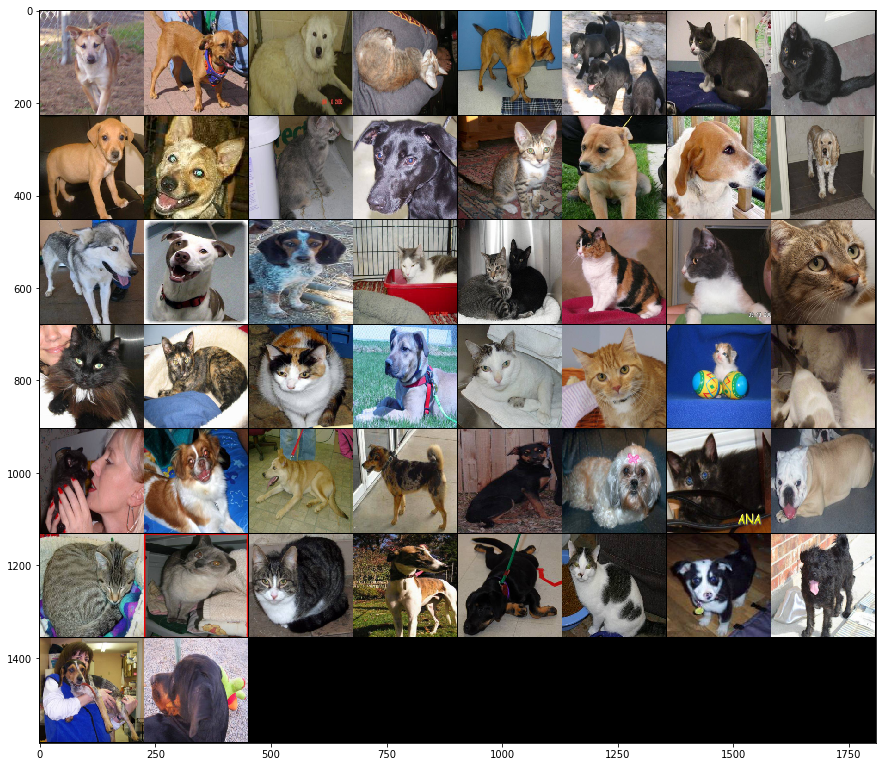

In [13]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(utils.make_grid(images, normalize=True))

### Define model : Transfer learning

In [14]:
from torchvision import models

In [15]:
model = models.resnet18(pretrained=True)

print('no of features :', model.fc.in_features)

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 10),
    nn.Linear(10, 2)
)

if is_cuda:
    model = model.cuda()

no of features : 512


In [16]:
loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# dynamically change the learning rate.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

### Training

In [17]:
def train_model(model, loss, optimizer, scheduler, num_epochs=10):

    for epoch in range(num_epochs):

        scheduler.step()
        
        batch_count = len(train_data)//batch_size
        print(batch_count)

        for i, (batch_images, batch_labels) in enumerate(train_loader):

            X = Variable(batch_images)
            Y = Variable(batch_labels)

            if is_cuda:
                X = batch_images.cuda()
                Y = batch_labels.cuda()

            pred = model(X)
            cost = loss(pred, Y)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

    #         if (i+1) == batch_count:
    #         if (i+1) % 10 == 0:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f' % (epoch+1, num_epochs, i+1, batch_count, cost.data[0]))

In [18]:
if is_cuda:
    train_model(model, loss, optimizer, exp_lr_scheduler, 10)
else:
    train_model(model, loss, optimizer, exp_lr_scheduler, 2)

10
Epoch [1/5], lter [1/10] Loss: 0.7308
Epoch [1/5], lter [2/10] Loss: 0.2199
Epoch [1/5], lter [3/10] Loss: 0.1971
Epoch [1/5], lter [4/10] Loss: 0.0928
Epoch [1/5], lter [5/10] Loss: 0.2549
Epoch [1/5], lter [6/10] Loss: 0.1865
Epoch [1/5], lter [7/10] Loss: 0.3455
Epoch [1/5], lter [8/10] Loss: 0.2988
Epoch [1/5], lter [9/10] Loss: 0.1621
Epoch [1/5], lter [10/10] Loss: 0.2286
10
Epoch [2/5], lter [1/10] Loss: 0.1515
Epoch [2/5], lter [2/10] Loss: 0.0811
Epoch [2/5], lter [3/10] Loss: 0.1763
Epoch [2/5], lter [4/10] Loss: 0.0896
Epoch [2/5], lter [5/10] Loss: 0.1208
Epoch [2/5], lter [6/10] Loss: 0.0815
Epoch [2/5], lter [7/10] Loss: 0.1624
Epoch [2/5], lter [8/10] Loss: 0.0543
Epoch [2/5], lter [9/10] Loss: 0.1402
Epoch [2/5], lter [10/10] Loss: 0.1337
10
Epoch [3/5], lter [1/10] Loss: 0.0347
Epoch [3/5], lter [2/10] Loss: 0.1132
Epoch [3/5], lter [3/10] Loss: 0.0708
Epoch [3/5], lter [4/10] Loss: 0.0156
Epoch [3/5], lter [5/10] Loss: 0.0312
Epoch [3/5], lter [6/10] Loss: 0.0355
E

KeyboardInterrupt: 

### Test

In [ ]:
model.eval()

correct = 0
total = 0

for i, (images, labels) in enumerate(train_loader):
    
    X = Variable(images.view(-1, 224 * 224))
    outputs = model(X)
    
    _, pred = torch.max(outputs.data, 1)  # arg max
    
    total += 1
    correct += (pred == labels).sum()
    
print('Accuracy of test images: %f %%' % (100 * correct / total))
print(correct, total)